In [1]:
category = 'apple' # 'apple'

# Imports

In [2]:
import os
from pathlib import Path

In [3]:
from itertools import product

In [4]:
import numpy as np

In [5]:
import torch

In [6]:
import clip

In [7]:
from PIL import Image, ImageDraw, ImageOps
import skimage

In [8]:
from tqdm import tqdm

In [9]:
import matplotlib.pyplot as plt

In [10]:
import logging

## Configs

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Setup

In [12]:
prefix = 'sketch of a'

---

In [13]:
categories = [category] + ['orange', 'tangerine', 'grapefruit', 'lemon']
# categories = [dirpath.name for dirpath in Path('data/sketch').glob('[!.]*')]

In [14]:
categories[np.argwhere(np.array(categories) == category).squeeze()] = categories[0]
categories[0] = category

In [15]:
labels = [f'{prefix} {label}'for label in categories]

In [16]:
model, preprocess = clip.load('ViT-B/32', device=device)

## Functions and Classes

In [17]:
class Im():
    BASE_DIR = 'data/sketch'

    def __init__(self, basename, category=category, prefix=''):
        self.category = category
        self.dirname = Path(Im.BASE_DIR, self.category, prefix)
        self.basename = basename
        self.path = self.dirname / self.basename
        if self.path.is_file():
            self.image = Image.open(self.path)

    def apply(self, func, *args, **kwargs):
        self.image = func(self.image, *args, **kwargs)
        return self

    def save(self, prefix=''):
        filepath = self.dirname / prefix / self.basename
        filepath.parent.mkdir(parents=True, exist_ok=True)
        self.image.save(filepath)

    @staticmethod
    def pixelate(image, step):
        return image.resize(tuple(map(lambda s: int(s / step), image.size)), resample=Image.Resampling.BILINEAR).convert('1').resize(image.size, Image.Resampling.NEAREST)

    def preprocess(self, step, save=False):
        self.apply(ImageOps.invert)
        my_grid = ShapeGridworld(step=step)
        my_grid.register(self.image)
        self.image = my_grid.render()
        if save:
            self.save(f'pre-processed_{step}' if step else '')

    def show(figsize=(10, 10)):
        fig = plt.figure(figsize=figsize)
        plt.axis("off")
        plt.imshow(self.render(), vmin=0, vmax=1)
        plt.show()

    def _ipython_display_(self):
        if self.image:
            display(self.image)

In [18]:
class ShapeGridworld():
    COLOR = 1 # (0.21568627450980393, 0.49411764705882355, 0.7215686274509804)

    def __init__(self, width=32, height=32, step=7, shape='circle'):
        self.width = width
        self.height = height
        self.shape = 'circle'
        self.step = step
        self.objects = np.zeros((self.height, self.width))
        self.create_kernel()

    def create_kernel(self):
        if self.shape == 'square':
            self.kernel = np.ones((self.step, self.step))
        elif self.shape == 'circle':
            radius = int(self.step/2)
            center = (radius,) * 2

            y, x = np.ogrid[:self.step, :self.step]
            dist_from_center = np.sqrt((x - center[0])**2 + (y - center[1])**2)

            self.kernel = dist_from_center <= radius

    def register(self, image):
        image = np.array(image.resize((self.width*self.step, self.height*self.step)))
        for i, j in product(range(self.height), range(self.width)):
            self.objects[i, j] = bool(np.tensordot(image[self.step*i:self.step*(i + 1), self.step*j:self.step*(j + 1)], self.kernel))

    def render(self):
        image = np.zeros((self.height*self.step, self.width*self.step), dtype=bool) # , 3), dtype=np.float32)
        for pos, val in np.ndenumerate(self.objects):
            if val:
                if self.shape == 'circle':
                    # image = Image.fromarray(image)
                    # ImageDraw.Draw(image).ellipse((pos[0]*self.step, pos[1]*self.step,  (pos[0] + 1)*self.step, (pos[0] + 1)*self.step), fill=ShapeGridworld.COLOR, outline=ShapeGridworld.COLOR)
                    # image = np.array(image)
                    rr, cc = skimage.draw.disk((pos[0]*self.step + self.step/2, pos[1]*self.step + self.step/2), self.step/2, shape=image.shape)
                    image[rr, cc] = ShapeGridworld.COLOR
                elif self.shape == 'square':
                    image[self.step*pos[0]:self.step*(pos[0] + 1), self.step*pos[1]:self.step*(pos[1] + 1)] = ShapeGridworld.COLOR

        image[:, ::self.step] = image[::self.step, :] = 1 # [1, 1, 1]

        return Image.fromarray(image)

---

In [19]:
def create_mask(size, step):
    image = Image.new('1', size, 'black')
    width, height = size
    image_draw = ImageDraw.Draw(image)
    for x in range(0, width - step + 1, step):
        for y in range(0, height - step + 1, step):
            image_draw.ellipse((x, y, x + step, y + step), fill = 'white', outline ='white')
    return image

In [20]:
def grid_cell_value(image, step, x, y, shape='square'):
    image = np.array(image)
    if shape == 'square':
        return image[x-int(step/2):x+int(step/2), y-int(step/2):y+int(step/2)].any()
    elif shape == 'circle':
        for (i, j), v in np.ndenumerate(image[x-int(step/2):x+int(step/2), y-int(step/2):y+int(step/2)]):
            if (np.sqrt((i - step/2)**2 + (j - step/2)**2) < (step/2)**2) and v:
                return True

In [21]:
def mask_grid(image, step, method='mask'): # 'grid'
    if method == 'mask':
        return Image.fromarray(np.array(create_mask(image.size, step)) * np.array(image))
    elif method == 'grid':
        grid_image = np.zeros(image.size, dtype=bool)
        for x, y in zip(*map(np.ravel, np.mgrid[0:image.size[0]:int(step/2), 0:image.size[1]:int(step/2)])):
            grid_image[x-int(step/2):x+int(step/2), y-int(step/2):y+int(step/2)] = grid_cell_value(image, step, x, y)
        return Image.fromarray(grid_image)

---

In [22]:
def shift_and_scale(image):
    pass

---

In [23]:
def show_images(filenames, step=None):
    if not len(filenames):
        logging.debug('[No files]')
        return
    fig, axs = plt.subplots(int(np.ceil(len(filenames)/10)), 10, figsize=(20, int(np.ceil(len(filenames)/10))*2), sharex=True, sharey=True)
    fig.set_facecolor('black')
    axs = iter(axs.ravel())
    for filename in filenames[::-1]:
        ax = next(axs)
        ax.imshow(Im(f'{filename}.png', prefix=f'pre-processed_{step}' if step else None).image, cmap='binary')
        ax.set_title(f'{results[filename][0]*100:.2f}', color='white')
        ax.axis('off')
    for ax in axs:
        ax.axis('off')

# Main

In [24]:
step = 7

In [25]:
overwrite = True

## Preprocess

In [26]:
# Pre-process Images
for basename in tqdm(os.listdir(dirname:=Path(Im.BASE_DIR, category))):
    if (dirname / basename).is_file():
        # Convert to *grid-style*
        if not (dirname / f'pre-processed_{step}' / basename).is_file() or overwrite:
            file = Im(basename, category)
            file.preprocess(step, save=True)
        else:
            file = Im(basename, category, f'pre-processed_{step}')

        # Process for CLIP
        if not (filepath:=dirname / f'processed_{step}' / (basename.split('.')[0] + '.pt')).is_file() or overwrite:
            image = preprocess(file.image).unsqueeze(0).to(device)
            filepath.parent.mkdir(parents=True, exist_ok=True)
            torch.save(image, filepath)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:03<00:00, 28.01it/s]


In [27]:
# Pre-process Labels
text = clip.tokenize(labels).to(device)

## Inference

In [28]:
results = dict()
for basename in tqdm(os.listdir(dirname:=Path(Im.BASE_DIR, category, f'processed_{step}'))):
    if (filepath:=dirname / basename).is_file():
        image = torch.load(filepath, map_location=device)
        with torch.no_grad():
            image_features = model.encode_image(image)
            text_features = model.encode_text(text)

            logits_per_image, logits_per_text = model(image, text)
            probs = logits_per_image.softmax(dim=-1).cpu().numpy()

        results[basename.split('.')[0]] = probs.squeeze()
        # print(f'Label probs: {probs}')
        # print(f'Label: {labels[np.argmax(probs)]}')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:43<00:00,  1.83it/s]


# Results

In [29]:
results = dict(sorted(results.items(), key=lambda r: r[1][0]))

In [30]:
right_images = list(filter(lambda filename: np.argmax(results[filename]) == 0, results))
wrong_images = list(filter(lambda filename: np.argmax(results[filename]) != 0, results))

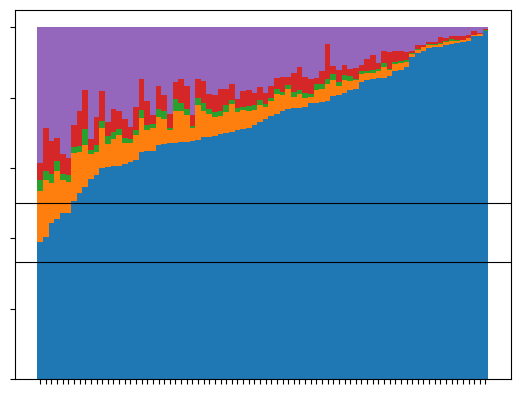

In [31]:
bottom = 0
for i in range(len(categories)):
    plt.bar(list(results.keys()), np.array(list(results.values()))[:, i], 1, bottom=bottom, label=categories[i])
    bottom += np.array(list(results.values()))[:, i]
plt.tick_params(labelbottom=False, labelleft=False)
plt.axhline(1/3, c='k', lw=0.8)
plt.axhline(0.5, c='k', lw=0.8)
# plt.axis('off')
# plt.legend()
plt.show()

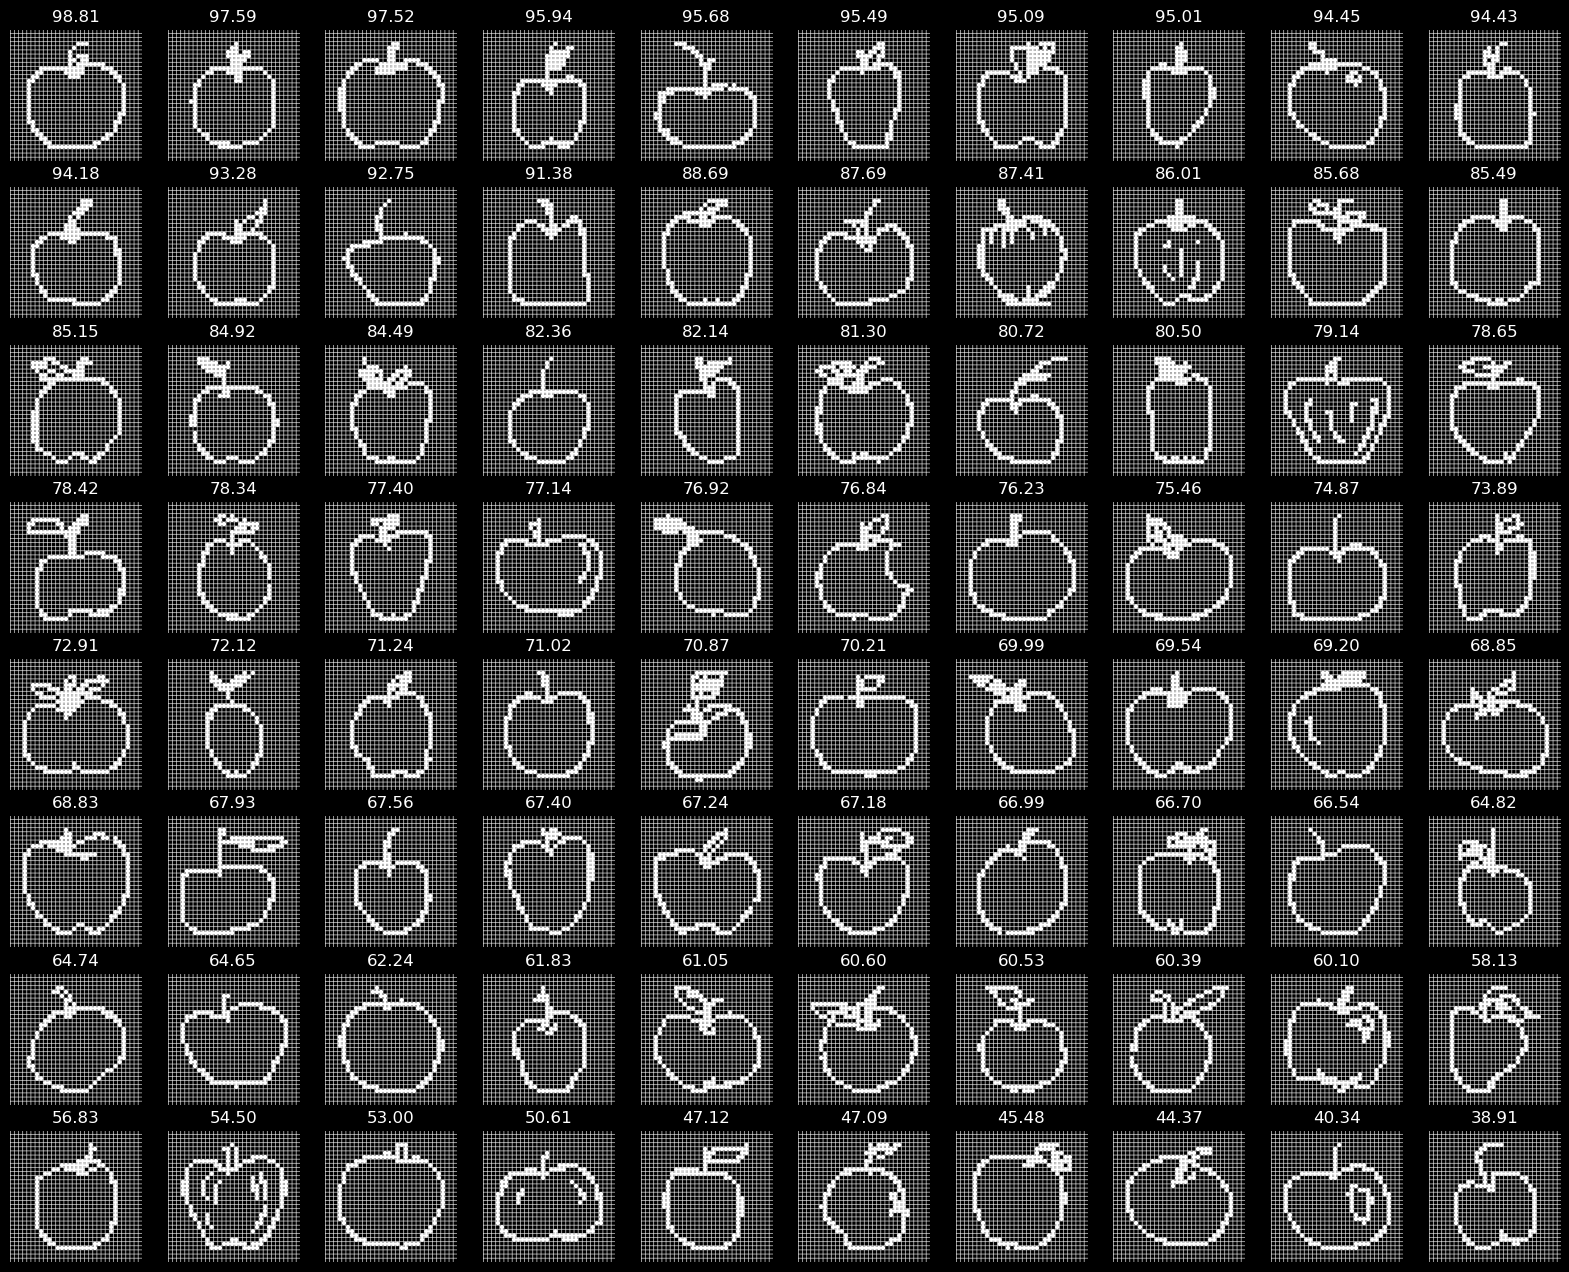

In [32]:
show_images(right_images, step)

In [33]:
show_images(wrong_images, step)